In [1]:
! pip install transformers datasets pytorch_metric_learning faiss-gpu umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! wget https://raw.githubusercontent.com/drchapman-17/LyricStyleSpace/main/data.json

--2023-03-20 17:32:46--  https://raw.githubusercontent.com/drchapman-17/LyricStyleSpace/main/data.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21129622 (20M) [text/plain]
Saving to: ‘data.json.5’

data.json.5         100%[===================>]  20.15M  --.-KB/s    in 0.06s   

2023-03-20 17:32:46 (317 MB/s) - ‘data.json.5’ saved [21129622/21129622]



## Preliminary Steps

In [3]:
from datasets import load_dataset
import numpy as np
import re
from matplotlib import pyplot as plt
from tqdm import tqdm


dataset = load_dataset('json',data_files='data.json').class_encode_column('artist')
artists_mappings = dataset['train'].features['artist'].names

  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
def clean(example):
    allowed_parts = ['verse','break','chorus','intro', 'interlude', 'bridge', 'outro']
    for part in allowed_parts:
        example['lyrics']=re.sub("\[.*"+part+".*\]", f"[{part}]", example['lyrics'], flags=re.IGNORECASE)
    example['lyrics']=re.sub("\[(?!"+"|".join(allowed_parts)+").*?\]", "", example['lyrics'], flags=re.DOTALL)
    example['lyrics']=re.sub("[0-9]+embed", "", example['lyrics'], flags=re.IGNORECASE)
    return example

mapped_dataset = dataset.map(clean)


In [5]:
def list_song_parts(example):
    parts = re.findall(r'\[[^\[\]]+\]',example['lyrics']) # Capture everything enclosed in square brackets
    for i,part in enumerate(parts): 
        parts[i] = re.sub(r':.*(?=\])','',part) # Remove everything from : to the closing bracket ] (Most lyrics contain the name of the singer of these parts e.g. [Chorus: 2 Chainz])
    return {'parts': parts}
parts = mapped_dataset['train'].map(list_song_parts,remove_columns=dataset['train'].column_names)

parts:np.ndarray = np.unique([el for l in parts['parts'] for el in l ])

In [6]:
print(*parts)

[break] [bridge] [chorus] [interlude] [intro] [outro] [verse]


In [7]:
# print(mapped_dataset)
print(dataset['train'][1000]['lyrics'])
print("----------------")
print(mapped_dataset['train'][1000]['lyrics'])

XO TOUR Llif3 Lyrics[Intro]
Are you alright?
I'm alright, I'm quite alright
And my money's right
8… (Yeah)
Countin' them bands
All way to the top 'til they be fallin' over
(Yeah, yeah, yeah)
Countin' them bands
On my way to the top 'til we fallin' over

[Chorus]
I don't really care if you cry
On the real, you shoulda never lied
Shoulda saw the way she looked me in my eyes
She said, "Baby, I am not afraid to die"
Push me to the edge
All my friends are dead
Push me to the edge
All my friends are dead
Push me to the edge
All my friends are dead
Push me to the edge

[Verse 1]
Phantom that's all red, inside all white
Like somethin' you ride a sled down, I just want that head
My Brittany got mad, I'm barely her man now
Everybody got the same swag now
Watch the way that I tear it down
Stackin' my bands all the way to the top
All the way 'til my bands fallin' over
Every time that you leave your spot
Your girlfriend call me like, "Come on over!"
I like the way that she treat me
Gon' leave you, 

In [8]:
allowed_parts = ['verse','break','chorus','intro', 'interlude', 'bridge', 'outro']
def contains_one_of(allowed_parts,part:str):
    for p in allowed_parts:
        if p in part.lower(): return True
    return False
filtered_parts = np.unique([part for part in parts if contains_one_of(allowed_parts,part)])

In [9]:
sorted(filtered_parts)

['[break]',
 '[bridge]',
 '[chorus]',
 '[interlude]',
 '[intro]',
 '[outro]',
 '[verse]']

# Preprocessing

In [10]:
def plot_dist(dataset):
    counts = {}
    for example in dataset:
        if example['artist'] not in counts.keys():
            counts[example['artist']] = 0
        else:
            counts[example['artist']] += 1
    plt.bar(counts.keys(), counts.values())

## Train Test Val Split

In [11]:
from datasets import DatasetDict
tts_mapped_dataset = mapped_dataset['train'].train_test_split(train_size=0.7)
mapped_dataset_valid = tts_mapped_dataset['test'].train_test_split(train_size=0.3)

train_test_val_dataset = DatasetDict({
    'train': tts_mapped_dataset['train'],
    'test':mapped_dataset_valid['test'],
    'val': mapped_dataset_valid['train']
    
})
train_test_val_dataset_filtered = train_test_val_dataset.filter(lambda example: example["artist"]<10)
train_test_val_dataset_filtered

Filter:   0%|          | 0/5029 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1510 [00:00<?, ? examples/s]

Filter:   0%|          | 0/646 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['artist', 'lyrics'],
        num_rows: 706
    })
    test: Dataset({
        features: ['artist', 'lyrics'],
        num_rows: 210
    })
    val: Dataset({
        features: ['artist', 'lyrics'],
        num_rows: 84
    })
})

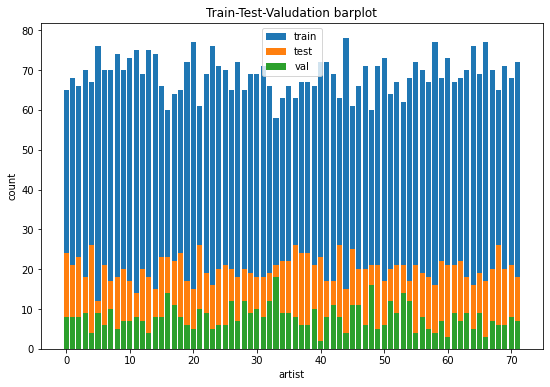

In [12]:
plt.figure(figsize=(9,6))
plt.title("Train-Test-Valudation barplot")
plt.ylabel("count")
plt.xlabel("artist")
plot_dist(train_test_val_dataset['train'])
plot_dist(train_test_val_dataset['test'])
plot_dist(train_test_val_dataset['val'])
plt.legend(['train', 'test', 'val'])
plt.show()

# Machine Learning

In [13]:
from transformers import AutoModel, AutoTokenizer

# Language Model Declaration:

modelckpt="bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(modelckpt)

In [14]:
# Tokenize
def prepare_train_features(examples):
    tokenized_examples = tokenizer(
        examples['lyrics'],
        truncation=True,
        padding=True,
        max_length=512
        )
    tokenized_examples['labels'] = examples['artist']
    return tokenized_examples

# train_features = train_test_val_dataset['train'].map(prepare_train_features, batched=True, remove_columns=train_test_val_dataset["train"].column_names).with_format('torch')
# test_features = train_test_val_dataset['test'].map(prepare_train_features, batched=True, remove_columns=train_test_val_dataset["test"].column_names).with_format('torch')
# val_features = train_test_val_dataset['val'].map(prepare_train_features, batched=True, remove_columns=train_test_val_dataset["val"].column_names).with_format('torch')

train_features = train_test_val_dataset_filtered['train'].map(prepare_train_features, batched=True, remove_columns=train_test_val_dataset["train"].column_names).with_format('torch')
test_features = train_test_val_dataset_filtered['test'].map(prepare_train_features, batched=True, remove_columns=train_test_val_dataset["test"].column_names).with_format('torch')
val_features = train_test_val_dataset_filtered['val'].map(prepare_train_features, batched=True, remove_columns=train_test_val_dataset["val"].column_names).with_format('torch')

Map:   0%|          | 0/706 [00:00<?, ? examples/s]

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

Map:   0%|          | 0/84 [00:00<?, ? examples/s]

In [15]:
from cycler import cycler

def visualize_embeddings(embeddings, labels):
  label_set = np.unique(labels)
  num_classes = len(label_set)
  plt.figure(figsize=(20,15))
  plt.gca().set_prop_cycle(
      cycler(
          "color", [plt.cm.nipy_spectral(i) for i in np.linspace(0,0.9, num_classes)]
      )
  )

  for i in range(num_classes):
    idx = (labels==label_set[i])
    plt.plot(embeddings[idx,0], embeddings[idx,1], ".", markersize=10, label=i)
  #plt.legend(loc="best", markerscale=10)
  plt.show()

In [16]:
from pytorch_metric_learning.samplers import MPerClassSampler
from torch.utils.data import Dataset,DataLoader

class MyDataset(Dataset):
    def __init__(self,dataset) -> None:
        super().__init__()
        self.dataset = dataset
    def __getitem__(self, index):
        index = int(index)
        return (self.dataset[index]['input_ids'],self.dataset[index]['attention_mask']),self.dataset[index]['labels']
    def __len__(self):
        return len(self.dataset)

labels = [int(label) for label in train_features['labels']]
m = 5
batch_size=len(np.unique(labels))*m

sampler = MPerClassSampler(labels, m, batch_size=batch_size, length_before_new_iter=100)


![![Z](attachment:image.png)](attachment:image.png)

In [17]:
from typing import Tuple, Iterator, Dict, Any, Sequence

import torch
from torch import Tensor
from torch.nn.utils.rnn import pad_sequence
import numpy as np

class EpisodicSampler(object):
    """Implement an Episodic sampler."""

    def __init__(self,
                 data: Sequence[Tuple[Tuple[Tensor,Tensor], Tensor]],
                 n_support: int,
                 n_query: int,
                 n_episodes: int,
                 n_classes: int = None,
                 balance_query: bool = False) -> None:
        """Initialize the EpisodicSampler.

        Parameters
        ----------
        data: Sequence[Tuple[torch.Tensor, torch.Tensor]]
            The input data as a list of (sequence, label) pairs
        n_support : int
            The number of support points per class
        n_query : int
            If balance_query is True, this should be the number
            of query points per class, otherwise, this is the total
            number of query points for the episode
        n_episodes : int
            Number of episodes to run in one "epoch"
        n_classes : int, optional
            The number of classes to sample per episode, defaults to all
        pad_index : int, optional
            The padding index used on sequences.
        balance_query : bool, optional
            If True, the same number of query points are sampled per
            class, otherwise query points are sampled uniformly
            from the input data.

        """

        self.n_support = n_support
        self.n_query = n_query
        self.n_classes = n_classes
        self.n_episodes = n_episodes

        self.balance_query = balance_query

        if len(data) == 0:
            raise ValueError("No examples provided")

        # Split dataset by target
        self.target_to_examples: Dict[int, Any] = dict()
        for source, target in data:
            self.target_to_examples.setdefault(int(target), []).append((source, target))

        self.all_classes = list(self.target_to_examples.keys())

    def __iter__(self) -> Iterator[Tuple[torch.Tensor, ...]]:
        """Sample from the list of features and yields batches.

        Yields
        ------
        Iterator[Tuple[Tensor, Tensor, Tensor, Tensor]]
            In order: the query_source, the query_target
            the support_source, and the support_target tensors.
            For sequences, the batch is used as first dimension.

        """
        for _ in range(self.n_episodes):
            # Sample n_classes to run a training episode over
            classes = self.all_classes
            if self.n_classes is not None:
                classes = list(np.random.permutation(self.all_classes))[:self.n_classes]

            # Sample n_support and n_query points per class
            supports, queries = [], []
            for i, target_class in enumerate(classes):
                examples = self.target_to_examples[target_class]
                indices = np.random.permutation(len(examples))
                supports.extend([(examples[j][0], i) for j in indices[:self.n_support]])

                if self.balance_query:
                    query_indices = indices[self.n_support:self.n_support + self.n_query]
                    queries.extend([(examples[j][0], i) for j in query_indices])
                else:
                    queries.extend([(examples[j][0], i) for j in indices[self.n_support:]])

            if not self.balance_query:
                indices = np.random.permutation(len(queries))
                queries = [queries[i] for i in indices[:self.n_query]]

            query_source, query_target = list(zip(*queries))
            support_source, support_target = list(zip(*supports))

            # query_source = pad_sequence(query_source,
            #                             batch_first=True,
            #                             padding_value=self.pad)
            query_input_ids,query_attention_mask = list(zip(*query_source))
            query_input_ids = torch.stack(query_input_ids)
            query_attention_mask = torch.stack(query_attention_mask)

            query_target = torch.tensor(query_target)

            support_input_ids,support_attention_mask = list(zip(*support_source))
            support_input_ids = torch.stack(support_input_ids)
            support_attention_mask = torch.stack(support_attention_mask)

            support_target = torch.tensor(support_target)

            if len(query_target.size()) == 2:
                query_target = query_target.squeeze()
            if len(support_target.size()) == 2:
                support_target = support_target.squeeze()

            yield (query_input_ids.long(),
                   query_attention_mask.long(),
                   query_target.long(),
                   support_input_ids.long(),
                   support_attention_mask.long(),
                   support_target.long())
    def __len__(self):
      return self.n_episodes

In [18]:
import torch
from transformers import AutoModel, AutoTokenizer
from torch import Tensor
from typing import Optional,Union,Tuple, Dict, Any


class PrototypicalTransformerModel(torch.nn.Module):
    
    def __init__(self,
                 model_ckpt: str,
                 output_dim: int) -> None:
        super().__init__()
        self.transformer = AutoModel.from_pretrained(model_ckpt)
        self.dense_layer = torch.nn.Linear(self.transformer.config.hidden_size, output_dim)

    def compute_prototypes(self, support: Tensor, label: Tensor) -> Tensor:
        """Set the current prototypes used for classification.

        Parameters
        ----------
        data : torch.Tensor
            Input encodings
        label : torch.Tensor
            Corresponding labels

        """
        means_dict: Dict[int, Any] = {}
        for i in range(support.size(0)):
            means_dict.setdefault(int(label[i]), []).append(support[i])

        means = []
        n_means = len(means_dict)

        for i in range(n_means):
            # Ensure that all contiguous indices are in the means dict
            supports = torch.stack(means_dict[i], dim=0)
            if supports.size(0) > 1:
                mean = supports.mean(0).squeeze(0)
            else:
                mean = supports.squeeze(0)
            means.append(mean)

        prototypes = torch.stack(means, dim=0)
        return prototypes
    def compute_embeddings(self,
                           query_input_ids : Tensor,
                           query_attention_mask : Tensor):
      query_embedding = self.transformer(input_ids = query_input_ids, attention_mask = query_attention_mask)
      return torch.nn.functional.relu(self.dense_layer(query_embedding["pooler_output"]))
      
    def forward(self,  # type: ignore
                query_input_ids: Tensor,
                query_attention_mask: Tensor,
                support_input_ids: Optional[Tensor] = None,
                support_attention_mask: Optional[Tensor] = None,
                support_label: Optional[Tensor] = None,
                prototypes: Optional[Tensor] = None) -> Union[Tensor, Tuple[Tensor, Tensor]]:
        """Run a forward pass through the network.
        
        Parameters
        ----------
        query: Tensor
            The query examples, as tensor of shape (seq_len x batch_size)
        support: Tensor
            The support examples, as tensor of shape (seq_len x batch_size)
        support_label: Tensor
            The support labels, as tensor of shape (batch_size)

        Returns
        -------
        Tensor
            If query labels are

        """

        query_encoding = self.compute_embeddings(query_input_ids=query_input_ids,query_attention_mask=query_attention_mask)
        
        if prototypes is not None:
            prototypes = prototypes
        elif support_input_ids is not None and support_attention_mask is not None and support_label is not None:
            support_encoding = self.compute_embeddings(query_input_ids=support_input_ids, query_attention_mask=support_attention_mask)
            prototypes = self.compute_prototypes(support_encoding, support_label)
        else:
          raise ValueError("No prototypes set or support vectors have been provided")

        dist = self.__euclidean_distance__(query_encoding, prototypes)
        clear_cache()

        return - dist
    
    def __euclidean_distance__(self, mat_1: Tensor, mat_2: Tensor):
        _dist = [torch.sum((mat_1 - mat_2[i])**2, dim=1) for i in range(mat_2.size(0))]
        dist = torch.stack(_dist, dim=1)
        return dist

In [19]:
import gc
def clear_cache():
  gc.collect()
  torch.cuda.empty_cache()
  torch.cuda.synchronize()
  # 
clear_cache()
print(f'{torch.cuda.memory_allocated()/1024**2} MB')
! nvidia-smi

0.0 MB
Mon Mar 20 17:32:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    28W /  70W |    103MiB / 15360MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+

In [20]:
device = 'cpu'
if torch.cuda.is_available():
  device='cuda'
  print('All good. A CPU is availbale')
else: 
  print('Restart the runtime with a compatible CUDA device.')

# Create model from pretrained checkpoint
model_ckpt = 'bert-base-uncased'
clear_cache()
model = PrototypicalTransformerModel(model_ckpt,128).to(device)
clear_cache()
print(torch.cuda.list_gpu_processes())

All good. A CPU is availbale


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


GPU:0
process     974475 uses     1038.000 MB GPU memory


In [21]:
import os 
from torch.utils.tensorboard import SummaryWriter

output_dir = 'out/prototype'

# Training hyperparameters
n_support = 3
n_query = 5
n_episodes = 10
n_classes = 4
eval_batch_size = 32

learning_rate= 1e-5

# Create samplers
train_sampler = EpisodicSampler(MyDataset(train_features),
                                n_support=n_support,
                                n_query=n_query,
                                n_episodes=n_episodes,
                                n_classes=n_classes)

# The train_eval_sampler is used to computer prototypes over the full dataset
# train_eval_sampler = BaseSampler(dataset.train, batch_size=eval_batch_size)
# val_sampler = BaseSampler(dataset.val, batch_size=eval_batch_size)



In [22]:
def train(model,train_sampler,train_eval_sampler,val_sampler,num_epochs,device):
    """Run Training """

    global_step = 0
    best_metric = None
    best_model: Dict[str, torch.Tensor] = dict()
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    writer = SummaryWriter(log_dir=output_dir)

    loss_fn = torch.nn.CrossEntropyLoss()

    parameters = (p for p in model.parameters() if p.requires_grad)
    optimizer = torch.optim.Adam(parameters, lr=learning_rate)

    print("Beginning training.")
    for epoch in tqdm(range(num_epochs)):

        ######################
        #       TRAIN        #
        ######################

        print(f'Epoch: {epoch}')

        model.train()

        with torch.enable_grad():
            for idx,batch in enumerate(tqdm(train_sampler)):
                # Zero the gradients and clear the accumulated loss
                optimizer.zero_grad()

                # Move to device
                batch = tuple(t.to(device) for t in batch)
                query_input_ids,query_attention_mask,query_label,support_input_ids,support_attention_mask,support_label = batch

                # Compute loss
                pred = model(query_input_ids,query_attention_mask, support_input_ids,support_attention_mask,support_label)
                loss = loss_fn(pred, query_label)
                loss.backward()
                clear_cache()
                # # Clip gradients if necessary
                # if args.max_grad_norm is not None:
                #     clip_grad_norm_(model.parameters(), args.max_grad_norm)

                writer.add_scalar('Training/Loss', loss.item(), global_step)

                # Optimize
                optimizer.step()
                global_step += 1

            # Zero the gradients when exiting a train step
            optimizer.zero_grad()

        # #########################
        # #       EVALUATE        #
        # #########################

        # model.eval()

        # with torch.no_grad():

        #     # First compute prototypes over the training data
        #     encodings, labels = [], []
        #     for text, label in train_eval_sampler:
        #         padding_mask = (text != model.padding_idx).byte()
        #         text_embeddings = model.embedding_dropout(model.embedding(text))
        #         text_encoding = model.encoder(text_embeddings, padding_mask=padding_mask)
        #         labels.append(label.cpu())
        #         encodings.append(text_encoding.cpu())
        #     # Compute prototypes
        #     encodings = torch.cat(encodings, dim=0)
        #     labels = torch.cat(labels, dim=0)
        #     prototypes = model.compute_prototypes(encodings, labels).to(device)

        #     _preds, _targets = [], []
        #     for batch in val_sampler:
        #         # Move to device
        #         source, target = tuple(t.to(device) for t in batch)

        #         pred = model(source, prototypes=prototypes)
        #         _preds.append(pred.cpu())
        #         _targets.append(target.cpu())

        #     preds = torch.cat(_preds, dim=0)
        #     targets = torch.cat(_targets, dim=0)

        #     val_loss = loss_fn(preds, targets).item()
        #     val_metric = (pred.argmax(dim=1) == target).float().mean().item()

        # # Update best model
        # if best_metric is None or val_metric > best_metric:
        #     best_metric = val_metric
        #     best_model_state = model.state_dict()
        #     for k, t in best_model_state.items():
        #         best_model_state[k] = t.cpu().detach()
        #     best_model = best_model_state

        # # Log metrics
        # print(f'Validation loss: {val_loss}')
        print(f'Training loss: {loss.item()}')
        # print(f'Validation accuracy: {val_metric}')
        # writer.add_scalar('Validation/Loss', val_loss, epoch)
        # writer.add_scalar('Validation/Accuracy', val_metric, epoch)

    # Save the best model
    print("Finished training.")
    torch.save(best_model, os.path.join(output_dir, 'model.pt'))


In [23]:
train(model,train_sampler,None,None,5,device)

Beginning training.


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0



 20%|██        | 1/5 [00:27<01:49, 27.32s/it]

Training loss: 1.3363711833953857
Epoch: 1



 40%|████      | 2/5 [00:47<01:08, 22.92s/it]

Training loss: 1.5583992004394531
Epoch: 2



 60%|██████    | 3/5 [01:06<00:42, 21.40s/it]

Training loss: 1.3724610805511475
Epoch: 3



 80%|████████  | 4/5 [01:26<00:20, 20.63s/it]

Training loss: 0.7952694296836853
Epoch: 4



100%|██████████| 5/5 [01:46<00:00, 21.32s/it]

Training loss: 1.6082336902618408
Finished training.


In [24]:
from torch.utils.data import DataLoader
def get_all_embeddings(dataset, model,device):
  dataloader = DataLoader(dataset,batch_size=16)
  embeddings = []
  labels = []
  model.eval()
  with torch.no_grad():
    for _,((input_ids,attention_mask),label), in enumerate(tqdm(dataloader)):
      labels.append(label)
      input_ids = input_ids.to(device)
      attention_mask = attention_mask.to(device)
      embeddings.append(model.compute_embeddings(query_input_ids=input_ids,query_attention_mask=attention_mask))
  return torch.vstack(embeddings), torch.cat(labels)

In [25]:
from cycler import cycler

def visualize_embeddings(embeddings, labels,label_mappings):
  label_set = np.unique(labels)
  num_classes = len(label_set)
  plt.figure(figsize=(20,15))
  plt.gca().set_prop_cycle(
      cycler(
          "color", [plt.cm.nipy_spectral(i) for i in np.linspace(0,0.9, num_classes)]
      )
  )

  for i in range(num_classes):
    idx = (labels==label_set[i])
    plt.plot(embeddings[idx,0], embeddings[idx,1], ".", markersize=10, label=label_mappings[label_set[i]])
  plt.legend(loc="best", markerscale=1)
  plt.show()

100%|██████████| 45/45 [00:22<00:00,  2.03it/s]


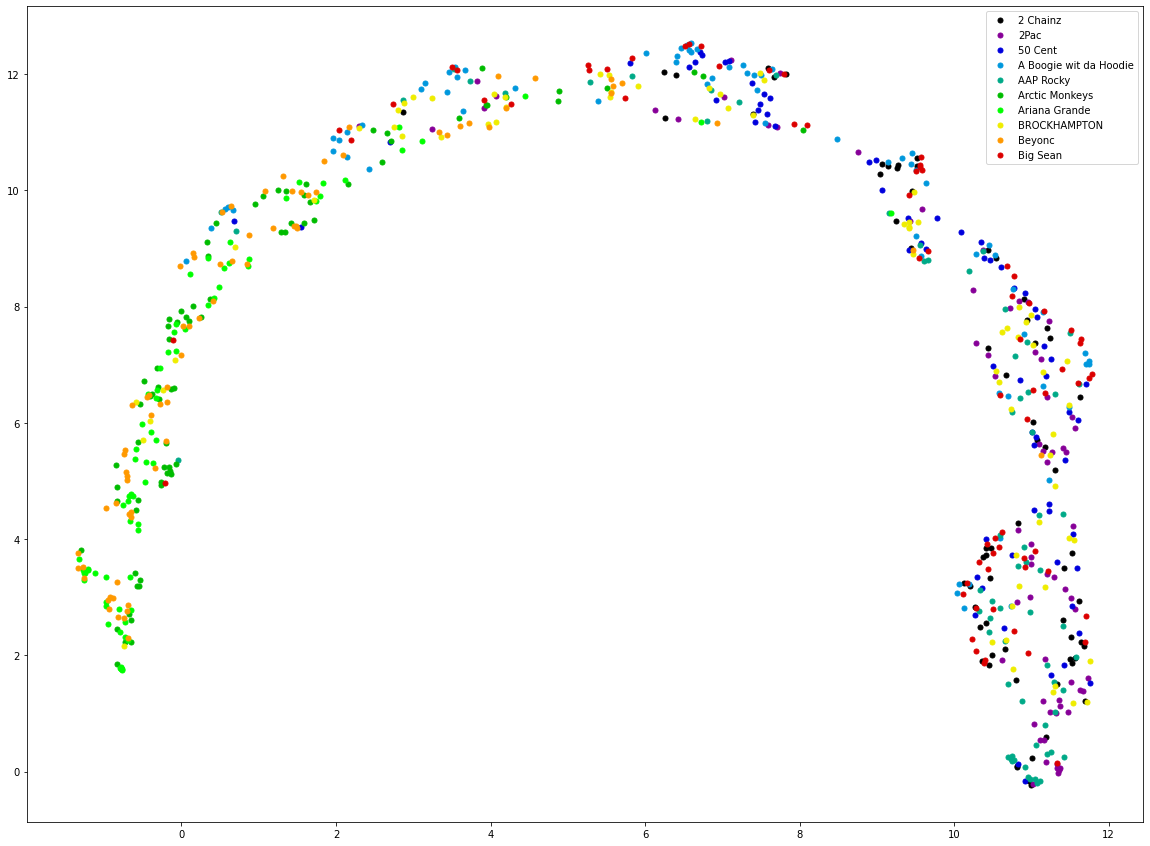

In [26]:
import umap
# Visualize the new embeddings 
umap_visualizer = umap.UMAP()
embeddings, labels = get_all_embeddings(MyDataset(train_features), model,device)
embeddings_reduced = umap_visualizer.fit_transform(embeddings.cpu().numpy())
visualize_embeddings(embeddings_reduced, labels.cpu().numpy(),artists_mappings)